In [1]:
import os
import sys
import scipy
from numba import njit, prange
import numpy as np
import scipy.stats as stats
import bayesflow as bf
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import pickle
import tensorflow as tf
import priors_and_simulators as ps
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import skew


# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(2023)

#Settings

NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
NUM_EPOCHS = 100

PARAM_NAMES = [
    r"$\gamma$",
    r"$\nu_{word}$",
    r"$\nu_{picture}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",

    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{\nu}$",
    r"$s_{\tau}$",
]

2024-11-08 12:16:00.837108: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 12:16:00.862099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 12:16:01.310103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook imp

# Define Prior

In [2]:
prior = bf.simulation.Prior(prior_fun=ps.gsr_ddm_prior_fun, param_names=PARAM_NAMES)

prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)

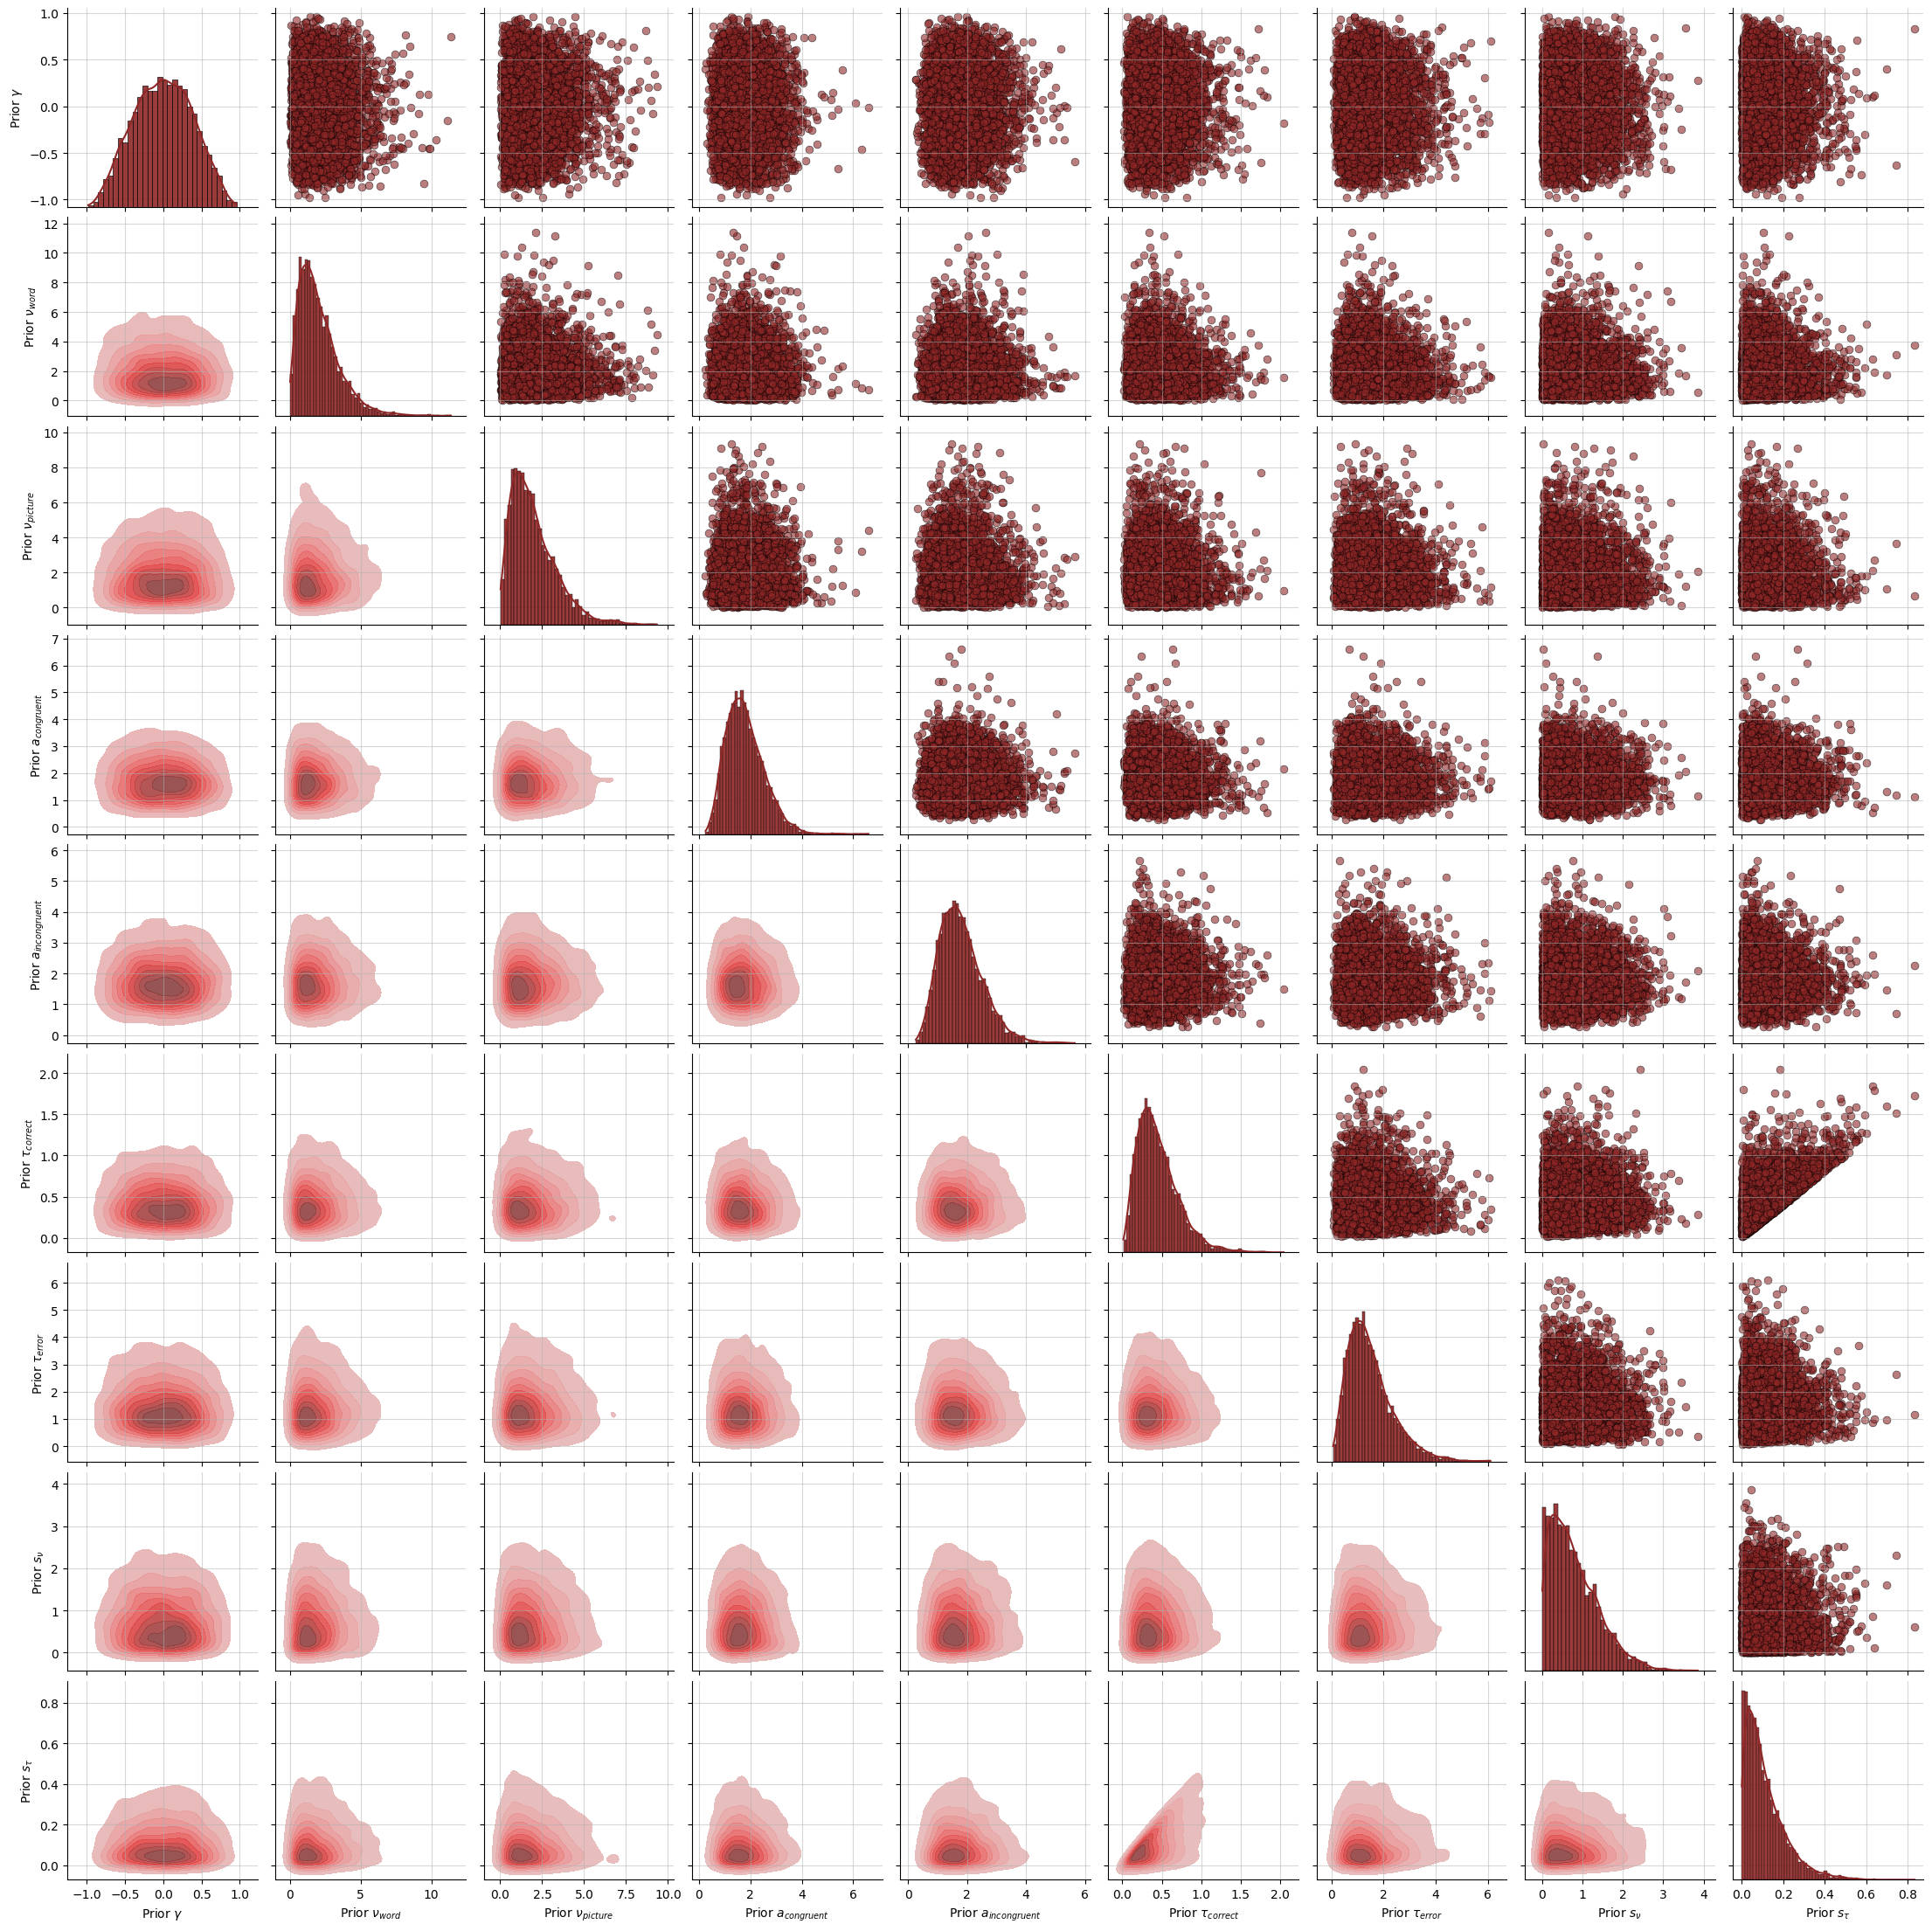

In [3]:
#Plot priors
f = prior.plot_prior2d(n_samples=5000)

# Define simulator and generative model

In [4]:
simulator = bf.simulation.Simulator(simulator_fun=ps.gsr_ddm_simulator_fun)

model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="GSR_DDM")

In [6]:
# Prior predictive checks
check_data = model(10000)["sim_data"]

rt_correct = check_data[:, :, 0].copy()
rt_correct[rt_correct < 0] = np.nan

rt_incorrect = check_data[:, :, 0].copy()
rt_incorrect[rt_incorrect > 0] = np.nan

rt_congruent_c = rt_correct[:, :60]
rt_incongruent_c = rt_correct[:, 60:121]


rt_congruent = check_data[:, :60, 0]
rt_incongruent = check_data[:, 60:121, 0]

rt_congruent_w = rt_incorrect[:, :60]
rt_incongruent_w = rt_incorrect[:, 60:121]

rt_congruent_idx = rt_congruent > 0
rt_incongruent_idx = rt_incongruent > 0

acc_congruent = rt_congruent_idx.sum(axis=1) / 60
acc_incongruent = rt_incongruent_idx.sum(axis=1) / 60

/tmp/ipykernel_307945/3886836059.py:5: RuntimeWarning: Mean of empty slice
  sns.kdeplot(np.abs(np.nanmean(rt_congruent_w, axis=1)), ax=axarr[1],
/tmp/ipykernel_307945/3886836059.py:9: RuntimeWarning: Mean of empty slice
  sns.kdeplot(np.abs(np.nanmean(rt_incongruent_w, axis=1)), ax=axarr[3], fill=True,


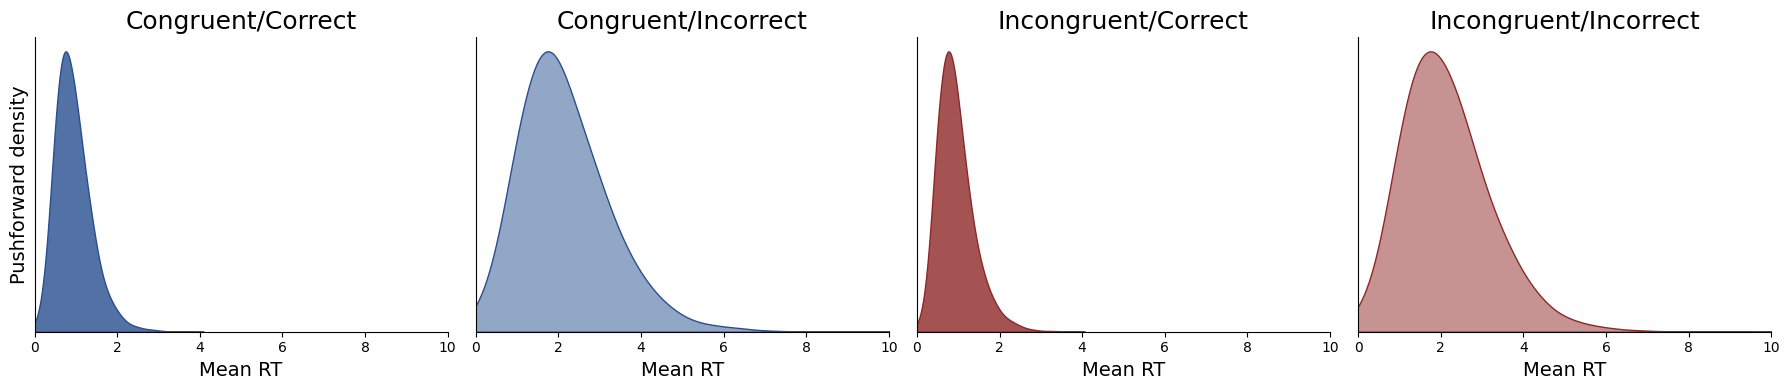

In [7]:
f, axarr = plt.subplots(1, 4, figsize=(18, 4))

sns.kdeplot(np.nanmean(rt_congruent_c, axis=1), ax=axarr[0],
            fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(np.abs(np.nanmean(rt_congruent_w, axis=1)), ax=axarr[1],
            fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(np.nanmean(rt_incongruent_c, axis=1), ax=axarr[2], fill=True,
            bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(np.abs(np.nanmean(rt_incongruent_w, axis=1)), ax=axarr[3], fill=True,
            bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, 10]) 
    sns.despine(ax=ax)
    ax.set_xlabel('Mean RT', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/gsr_Prior_Meanrt.png', dpi=300)


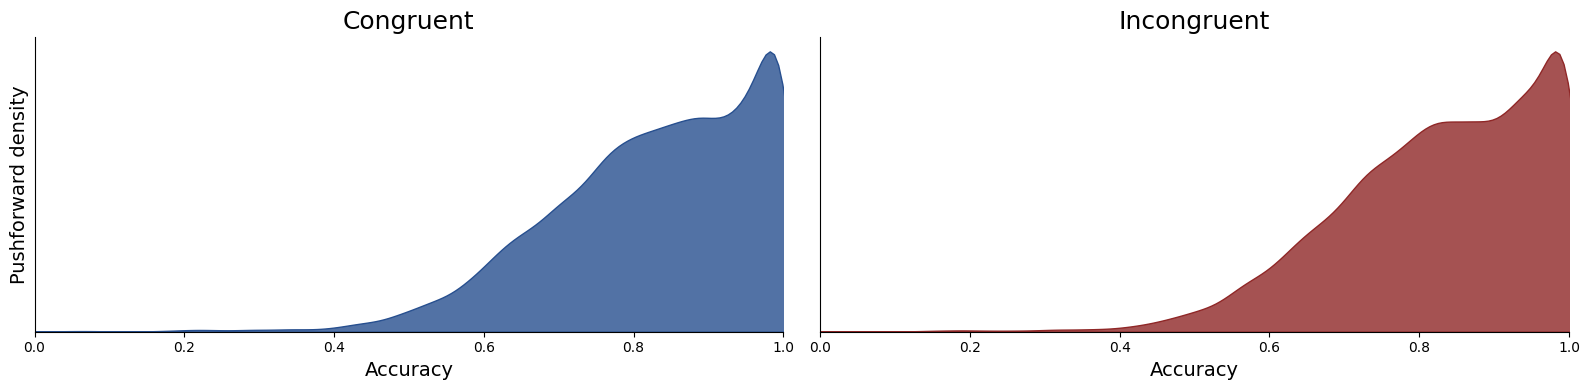

In [8]:
f, axarr = plt.subplots(1, 2, figsize=(16, 4))

sns.kdeplot(acc_congruent, ax=axarr[0], fill=True, color='#274f8f', alpha=0.8)
sns.kdeplot(acc_incongruent, ax=axarr[1], fill=True, color='#8f2727', alpha=0.8)

labels = ['Congruent', 'Incongruent']

for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, 1.0])
    sns.despine(ax=ax)
    ax.set_xlabel('Accuracy', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
f.tight_layout()
f.savefig('figures/gsr_Prior_Accuracy.png', dpi=300)


/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


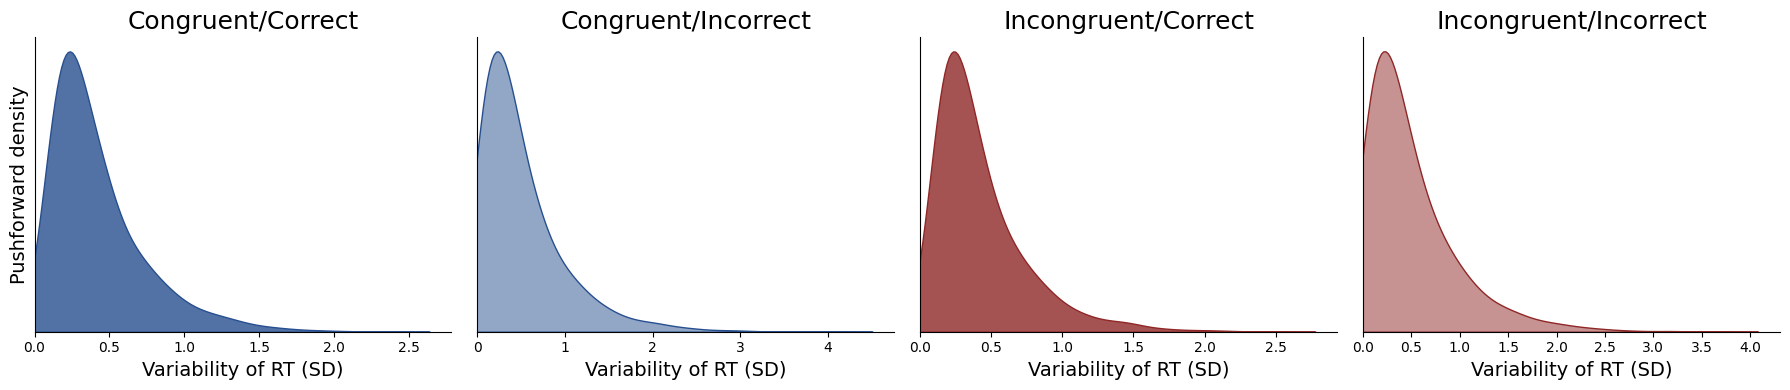

In [10]:
f, axarr = plt.subplots(1, 4, figsize=(18, 4))

sns.kdeplot(np.nanstd(rt_congruent_c, axis=1), ax=axarr[0],
            fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(np.nanstd(rt_congruent_w, axis=1), ax=axarr[1], fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(np.nanstd(rt_incongruent_c, axis=1), ax=axarr[2], fill=True, bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(np.nanstd(rt_incongruent_w, axis=1), ax=axarr[3], fill=True, bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, ax.get_xlim()[1]])
    sns.despine(ax=ax)
    ax.set_xlabel('Variability of RT (SD)', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/gsr_Prior_Varrt.png', dpi=300)


/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


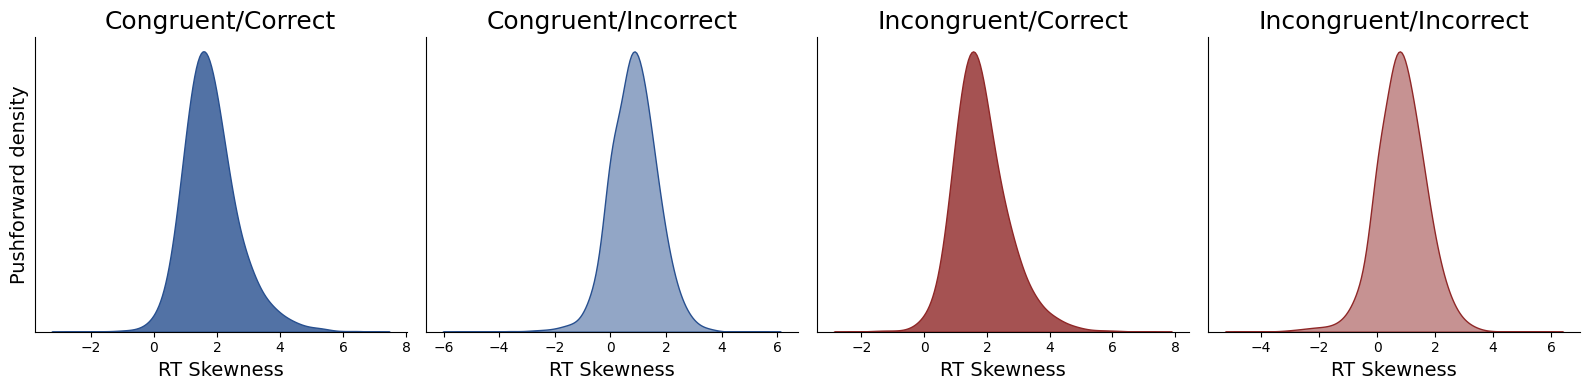

In [13]:
f, axarr = plt.subplots(1, 4, figsize=(16, 4))

sns.kdeplot(skew(rt_congruent_c, axis=1, nan_policy='omit'), ax=axarr[0],
            fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(skew(np.abs(rt_congruent_w), axis=1, nan_policy='omit'), ax=axarr[1], fill=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(skew(rt_incongruent_c, axis=1, nan_policy='omit'), ax=axarr[2], fill=True, bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(skew(np.abs(rt_incongruent_w), axis=1, nan_policy='omit'), ax=axarr[3], fill=True, bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    sns.despine(ax=ax)
    ax.set_xlabel('RT Skewness', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/gsr_Prior_Skewrt.png', dpi=300)

# Define configurator

In [5]:
def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    out_dict = {}
    out_dict["summary_conditions"] = forward_dict["sim_data"]
    params = forward_dict["prior_draws"].astype(np.float32)
    # Standardize parameters
    out_dict["parameters"] = (params - prior_means) / prior_stds
    
    return out_dict

# Define summary net, inference net, amortizer, trainer

In [6]:

summary_net = bf.networks.SetTransformer(input_dim=4, summary_dim=20, name="ddm_summary")

inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    coupling_design="spline",
    name="ddm_inference")

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="ddm_amortizer",
                                            summary_loss_fun='MMD')

# adjust checkpoint path if second training for ensemble checks is required
trainer = bf.trainers.Trainer(
    generative_model=model, amortizer=amortizer, configurator= configurator,
    checkpoint_path="gsr_ddm_120_net2")

INFO:root:Performing 2 pilot runs with the GSR_DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
2024-11-08 12:17:14.733749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 12:17:14.751517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at leas

# Run training

In [13]:
def presimulator(x):
    file_list = [{} for _ in range(NUM_ITERATIONS_PER_EPOCH)]

    for k in range(NUM_ITERATIONS_PER_EPOCH):
        file_list[k] = model(BATCH_SIZE)       
        
    with open('gsr_sims/presim_file_'+str(x)+'.pkl', 'wb+') as f:
        pickle.dump(file_list, f)
        
# Pre-simulate data for offline training (much faster due to parallel processing)        
if __name__ == '__main__':
    with Pool(processes=25) as pool:       
        pool.map(presimulator, range(NUM_EPOCHS))

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         1e-4, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=1e-8, name=None))

losses = trainer.train_from_presimulation('gsr_sims', optimizer = optimizer,
                                         reuse_optimizer=True)

Training epoch 1:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-10 17:40:15.781031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77e588012d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-10 17:40:15.781049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-10 17:40:15.783433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 17:40:15.789808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-10 17:40:15.852074: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training epoch 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
#trainer = bf.trainers.Trainer(
#    generative_model=model, amortizer=amortizer, configurator= configurator,
#    checkpoint_path="gsr_ddm_120_net2")
#
#optimizer = tf.keras.optimizers.Adam(learning_rate=
#                                     tf.keras.optimizers.schedules.CosineDecay(
#                                         1e-4, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=1e-8, name=None))
#
#
#losses = trainer.train_from_presimulation('gsr_sims', optimizer = optimizer,
#                                         reuse_optimizer=True)

INFO:root:Loaded loss history from gsr_ddm_120_net2/history_100.pkl.
INFO:root:Networks loaded from gsr_ddm_120_net2/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Training epoch 1:   0%|          | 0/10000 [00:00<?, ?it/s]


KeyboardInterrupt



# Diagnostics

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


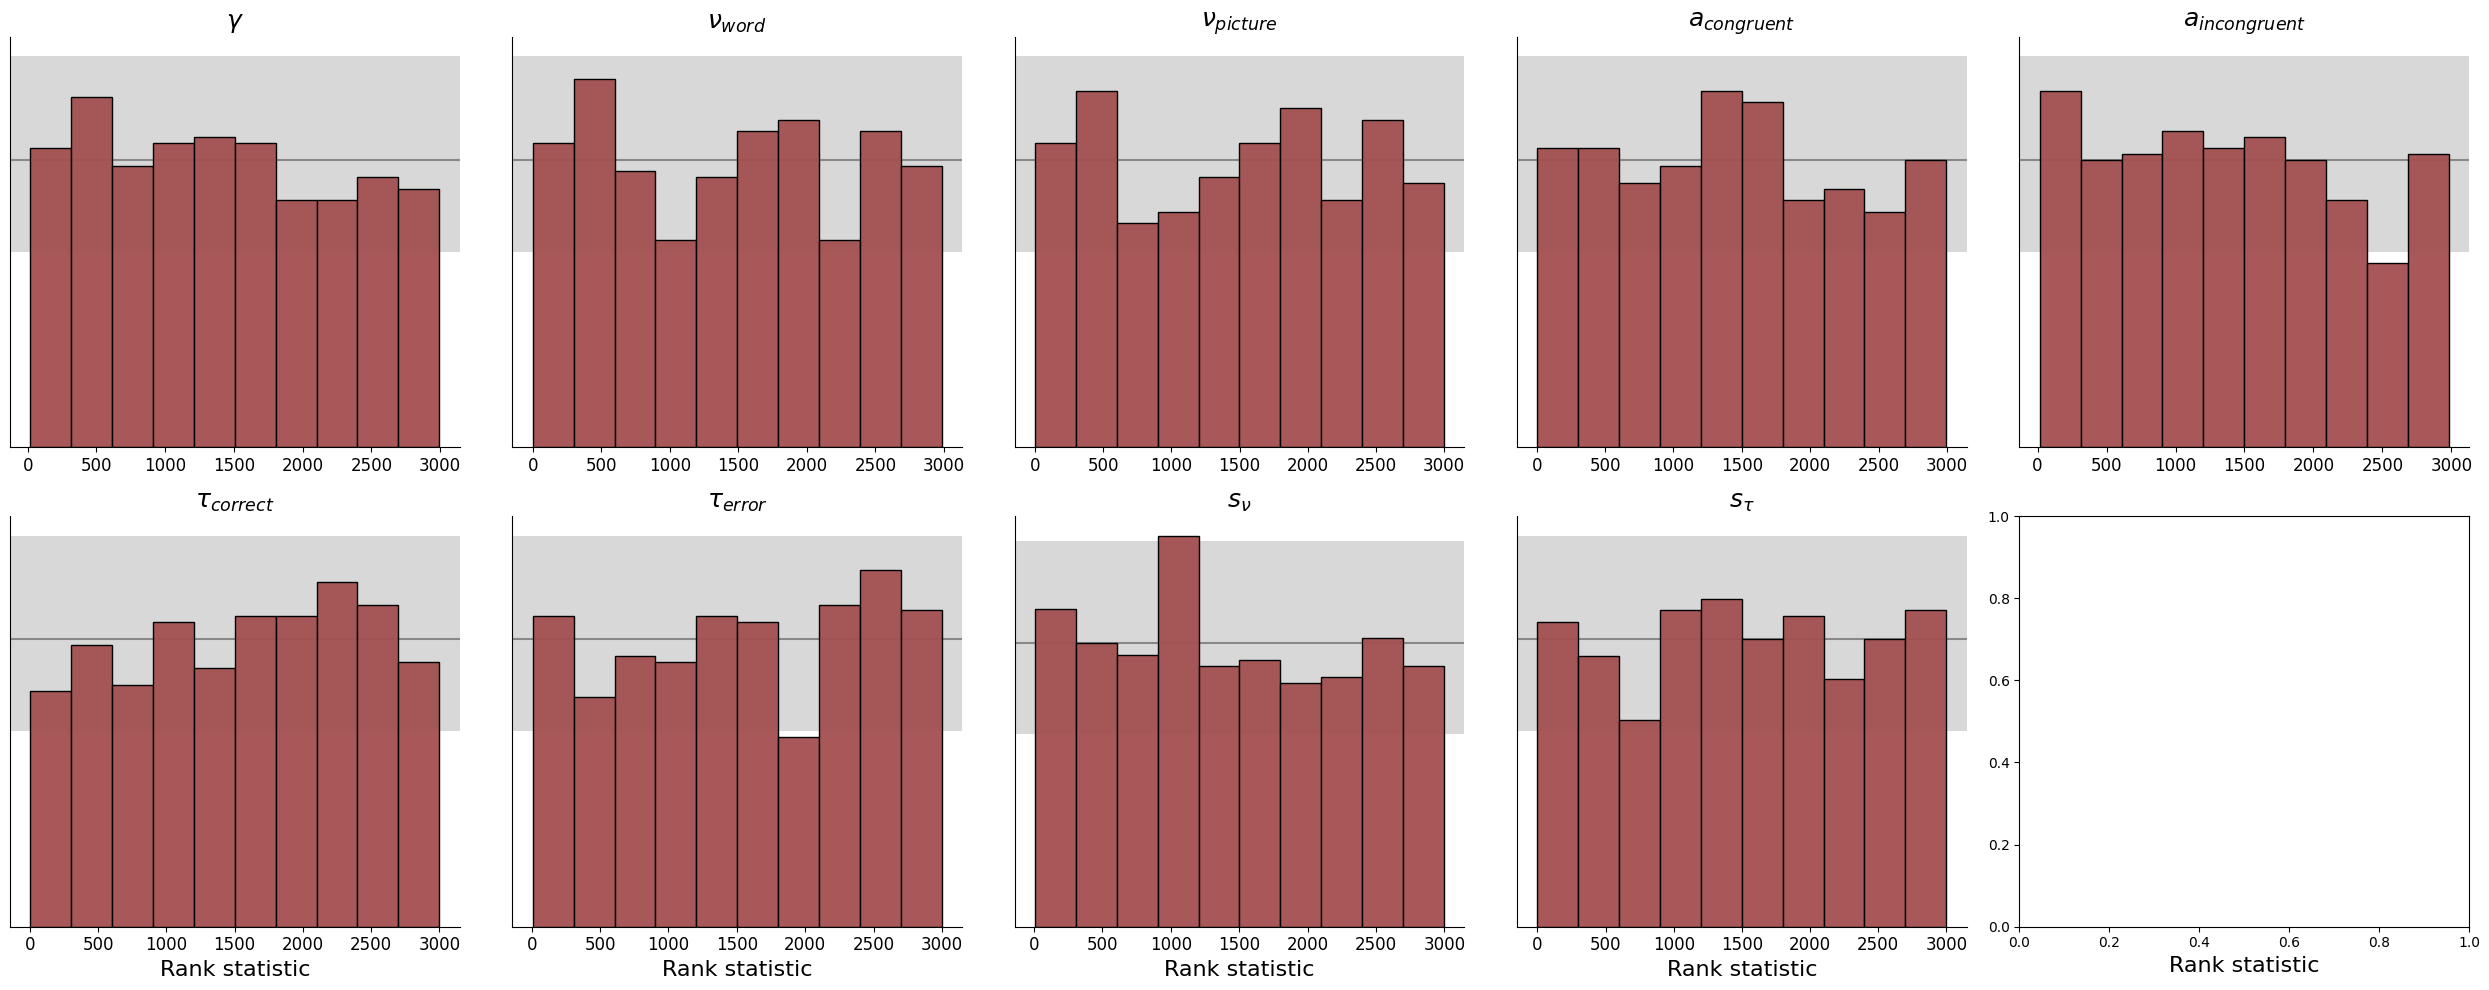

In [7]:
# Plot simulation-based calibration

# Generate some validation data
validation_sims = configurator(model(batch_size=500))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"] * prior_stds + prior_means

# Generate 3000 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer.sample(validation_sims, n_samples=3000)

# Unstandardize posterior draws into original scale
post_samples = post_samples * prior_stds + prior_means

f = bf.diagnostics.plot_sbc_histograms(post_samples, prior_samples, num_bins=10, param_names=PARAM_NAMES)

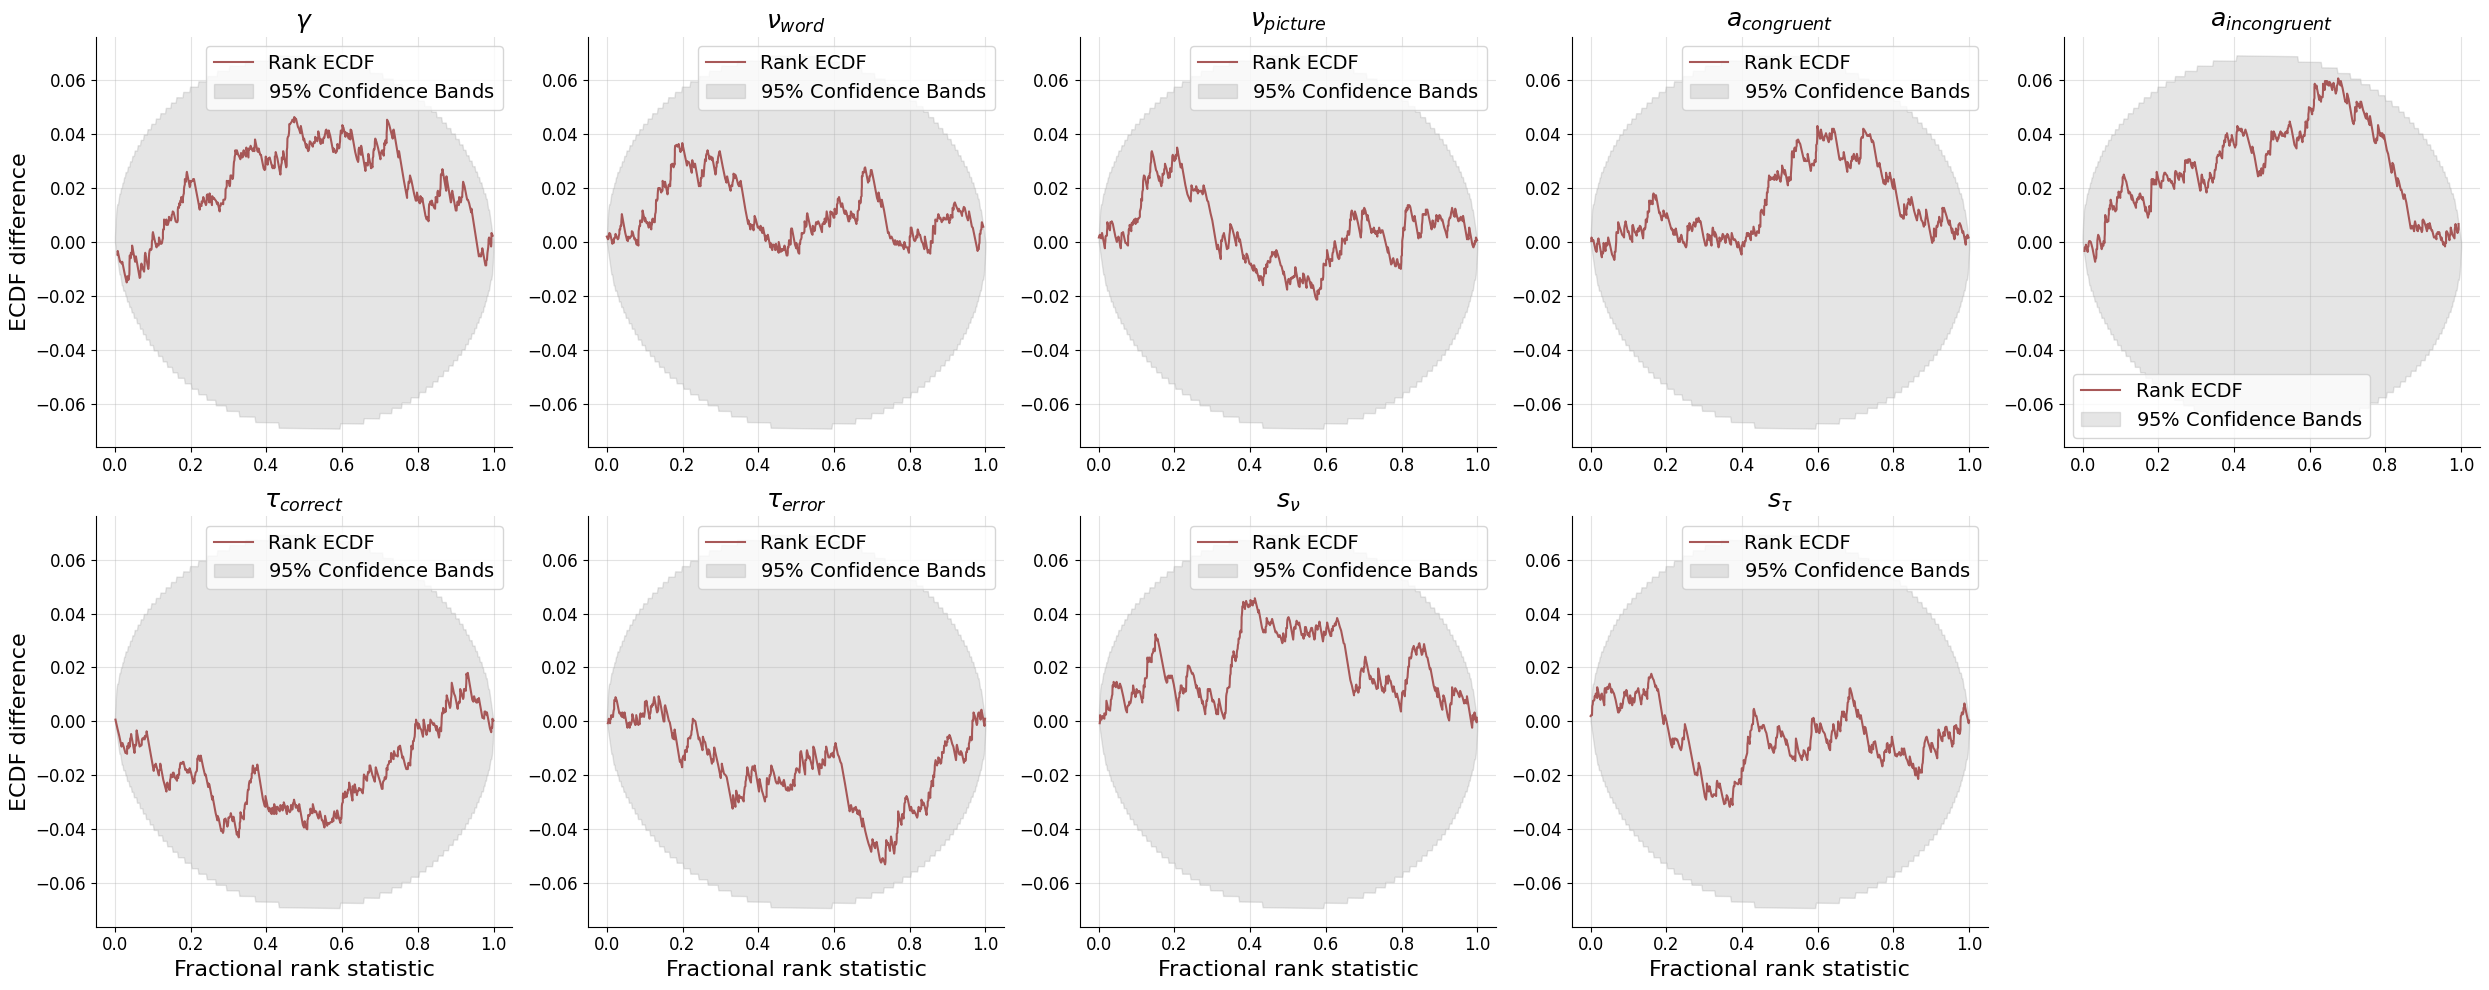

In [8]:
# Plot rank ECDFs

f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, stacked=False,
                                 difference=True, param_names=PARAM_NAMES)

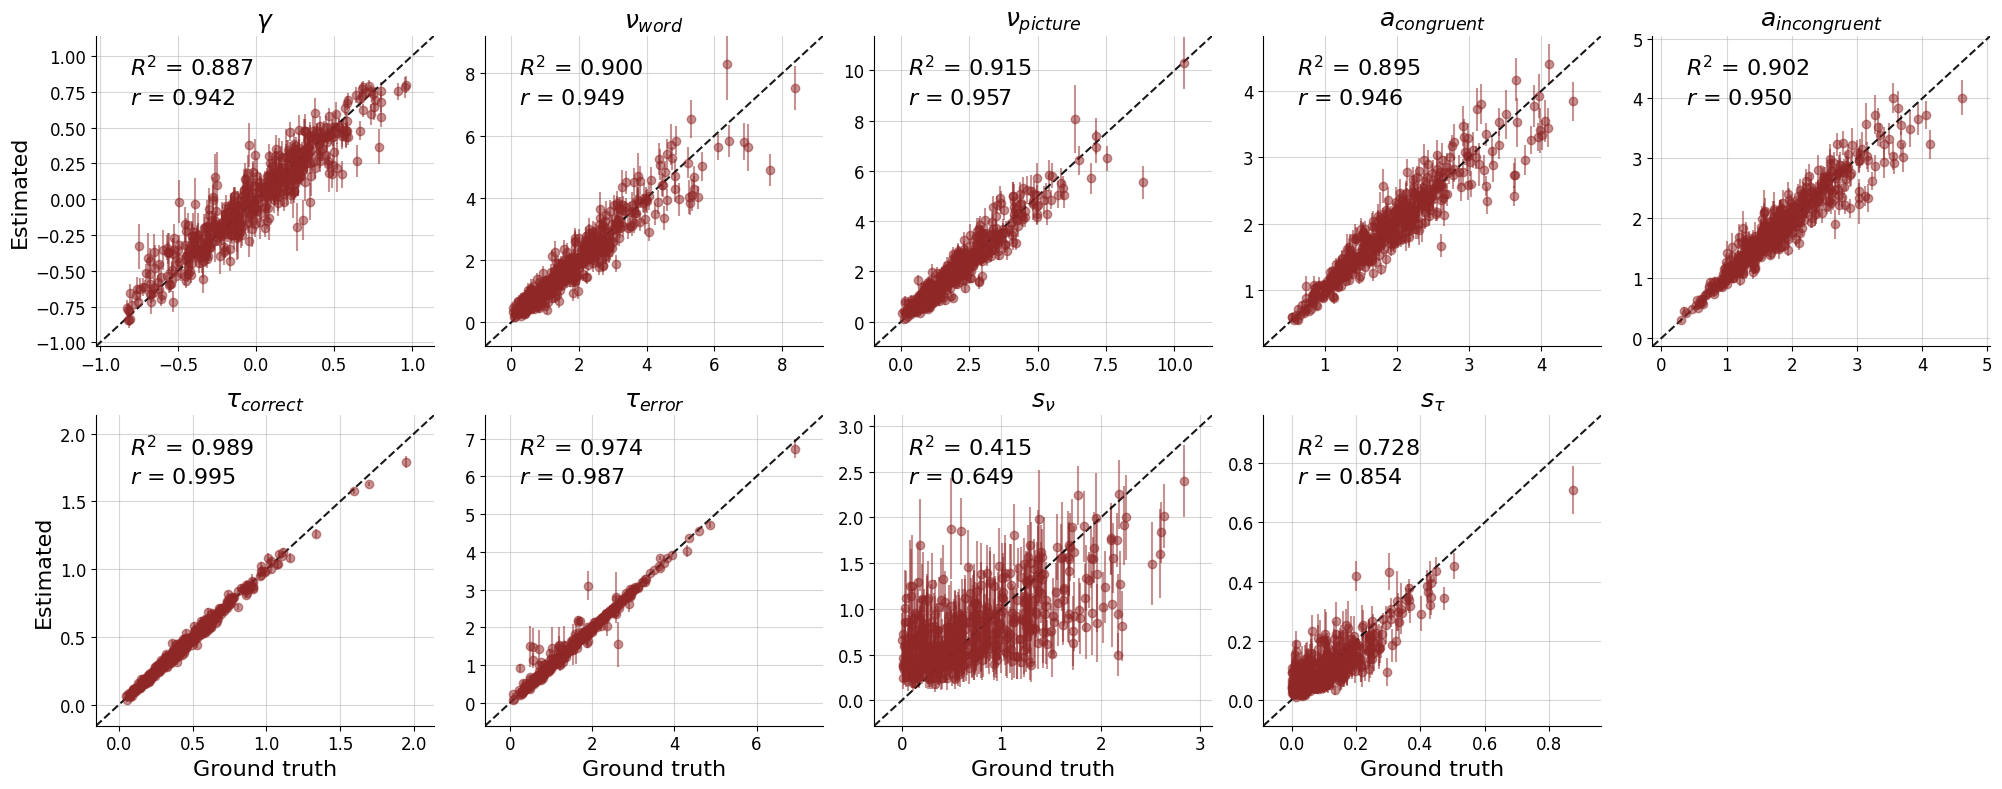

In [9]:
# Plot recovery scatterplots

post_samples = amortizer.sample(validation_sims, n_samples=3000)
post_samples = post_samples * prior_stds + prior_means

f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean
)

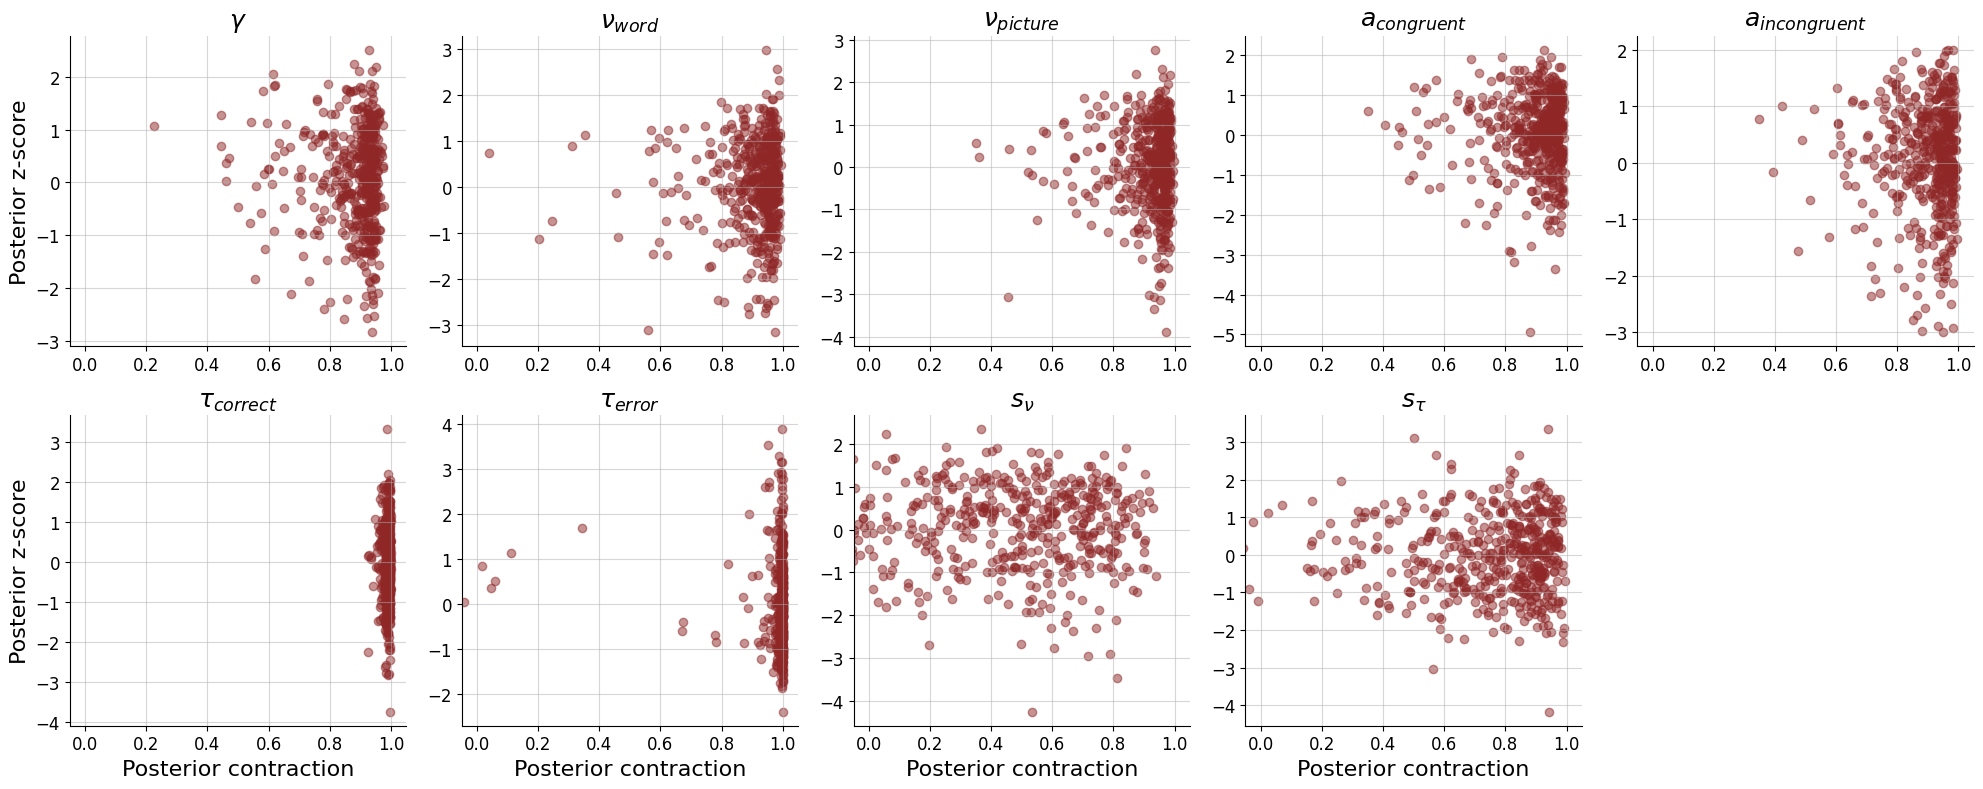

In [10]:
# Plot posterior contraction
f = bf.diagnostics.plot_z_score_contraction(post_samples, prior_samples, param_names=prior.param_names)

250.62796216970233


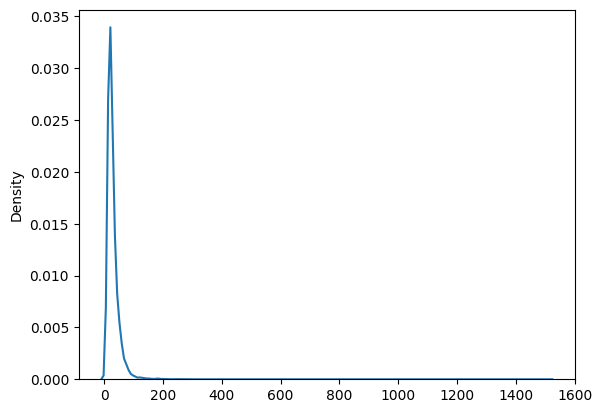

In [10]:
# Get mahalanobis distances distribution for data generated from the model 

simulations = trainer.configurator(trainer.generative_model(10000))
summary_statistics = trainer.amortizer.summary_net(simulations["summary_conditions"])

cov = EmpiricalCovariance().fit(summary_statistics)
mahalanobis_from_sims = cov.mahalanobis(summary_statistics)
mahalanobis_quantile_from_sims = np.quantile(mahalanobis_from_sims, 0.999) # arbitrary quantiles

sns.kdeplot(mahalanobis_from_sims)
print(mahalanobis_quantile_from_sims)